# 102 · COVID-Phasen & Heimvorteil in Europas Top-Ligen

**Ziel:** Prüfen, ob und wie sich der Heimvorteil in den COVID-Phasen verändert hat.  
Wir messen den Heimvorteil als **ΔPPG = Punkte(Home) − Punkte(Away)** (alternativ: Tordifferenz) und vergleichen **Pre-Covid**, **Geisterspiele** (2019/20 & 2020/21), **Teilzulassung** (2021/22) und **Post-Covid**.

**Kernfragen**
1) Wie groß ist ΔPPG je Phase (gesamt & je Liga)?  
2) Sind die Unterschiede signifikant (ANOVA / paarweise t-Tests)?  
3) (Optional) Bleiben Phaseneffekte bestehen, wenn wir für Pre-Match-Faktoren kontrollieren (Quoten-Wahrsch. `p_home`, xP/xPTS)?

**Inputs**
- `data/matches/**` (wie in Notebook 100, football-data.co.uk)
- `data/corona_phases.csv` mit Spalten: `Phase;Start;End;Description` (Datum **TT.MM.JJJJ**)




**Phasen:** Pre-Covid · GhostGames 2019/20 · GhostGames 2020/21 · PartialFans 2021/22 · Post-Covid

**Kernfragen**
1) Wie groß ist ΔPPG je Phase (gesamt & je Liga)?
2) Sind die Unterschiede signifikant (ANOVA + paarweise Tests, Holm-Korrektur)?
3) Optional: Bleibt der Effekt bestehen, wenn wir einfache Pre-Match-Faktoren kontrollieren (z. B. p_home, xP/xPTS)?

**Inputs**
- `matches` (aus Notebook 100; C0 lädt es zur Not nach)
- `data/corona_phases.csv` mit Spalten: `Phase;Start;End;Description` (Datum TT.MM.JJJJ)

**Output**
- Tabellen mit Mittelwerten, 95%-CI, p-Werten, Effektstärken
- Plots: ΔPPG je Phase, Zeitreihe mit Phasen-Bändern, League-Splits


In [36]:
# C0 — Prereq-Guard: stelle sicher, dass `matches` existiert (falls 100 noch nicht lief)
import pandas as pd, numpy as np, re
from pathlib import Path

# Helper, falls sie aus 100 nicht im Kernel sind
if 'season_sort_key' not in globals():
    def season_sort_key(s):
        try: return 2000 + int(str(s).split("-")[0])
        except Exception: return 9999

if 'parse_date' not in globals():
    def parse_date(x: pd.Series) -> pd.Series:
        return pd.to_datetime(x, errors="coerce", dayfirst=True)

if 'add_points' not in globals():
    def add_points(df: pd.DataFrame) -> pd.DataFrame:
        map_h, map_a = {"H":3,"D":1,"A":0}, {"H":0,"D":1,"A":3}
        df["HomePoints"]=df["FTR"].map(map_h).astype(float)
        df["AwayPoints"]=df["FTR"].map(map_a).astype(float)
        df["DeltaPoints"]=df["HomePoints"]-df["AwayPoints"]
        df["GoalDiff"]=df["FTHG"].astype(float)-df["FTAG"].astype(float)
        return df

def read_csv_robust(path: Path) -> pd.DataFrame:
    """Robustes Lesen ohne low_memory: C-Engine (',' / ';'), dann Python-Engine (Sniffer), Encoding-Fallback."""
    encodings = ("utf-8","utf-8-sig","cp1252","latin-1")
    last_err = None
    for enc in encodings:
        try:
            return pd.read_csv(path, engine="c", sep=",", encoding=enc, on_bad_lines="skip")
        except Exception as e:
            last_err = e
        try:
            return pd.read_csv(path, engine="c", sep=";", encoding=enc, on_bad_lines="skip")
        except Exception as e:
            last_err = e
        try:
            return pd.read_csv(path, engine="python", sep=None, encoding=enc, on_bad_lines="skip")
        except Exception as e:
            last_err = e
            continue
    # letzter Versuch
    return pd.read_csv(path, engine="python", sep=";", encoding="latin-1", on_bad_lines="skip")

if 'matches' not in globals():
    print("ℹ️ `matches` nicht gefunden – lade Top-5-Daten …")

    DIV_TO_LEAGUE = {"D1":"Bundesliga","E0":"Premier League","SP1":"La Liga","F1":"Ligue 1","I1":"Serie A"}
    LEAGUE_CANON = {
        "1. Bundesliga":"Bundesliga","Bundesliga":"Bundesliga",
        "Premier League":"Premier League",
        "La Liga Primera Division":"La Liga","La Liga":"La Liga",
        "Le Championnat":"Ligue 1","Ligue 1":"Ligue 1",
        "Serie A":"Serie A",
    }
    TOP5 = {"Bundesliga","Premier League","La Liga","Ligue 1","Serie A"}
    EXCLUDE_SEASONS = {"25-26"}

    def season_compact(s: str) -> str:
        s = str(s)
        m = re.search(r"(\d{4})[.\-_/](\d{4})", s)
        if m: return f"{m.group(1)[-2:]}-{m.group(2)[-2:]}"
        m2 = re.search(r"(\d{2})[.\-_/](\d{2})", s)
        return f"{m2.group(1)}-{m2.group(2)}" if m2 else s

    def find_match_root(start: Path = Path.cwd()) -> Path:
        for base in [start, *start.parents]:
            cand = base / "data" / "matches"
            if cand.exists(): return cand
        raise FileNotFoundError("data/matches nicht gefunden")

    def detect_league(csv_path: Path, df: pd.DataFrame, root: Path) -> str | None:
        if "Div" in df.columns:
            div_raw = str(df["Div"].iloc[0]).strip().upper()
            if div_raw in DIV_TO_LEAGUE:
                return DIV_TO_LEAGUE[div_raw]
        parts = csv_path.relative_to(root).parts
        if len(parts) >= 3:
            lg = parts[1]
            return LEAGUE_CANON.get(lg, lg)
        if len(parts) >= 1:
            lg = parts[0]
            return LEAGUE_CANON.get(lg, lg)
        if "League" in df.columns:
            return str(df["League"].iloc[0])
        return None

    def load_matches_min(root: Path, strict_top5: bool = True) -> pd.DataFrame:
        rows = []
        for csv in root.rglob("*.csv"):
            try:
                df = read_csv_robust(csv)
            except Exception:
                continue
            if not {"Date","HomeTeam","AwayTeam","FTHG","FTAG","FTR"}.issubset(df.columns):
                continue
            league = detect_league(csv, df, root)
            if not league:
                continue
            league = LEAGUE_CANON.get(league, league)
            if strict_top5 and league not in TOP5:
                continue
            season = season_compact(csv.parent.name)
            df = df.copy()
            df["League"] = league
            df["Season"] = season
            df["Date"]   = parse_date(df["Date"])
            rows.append(df)
        if not rows:
            raise RuntimeError("Keine passenden CSVs gefunden – prüfe Ordnerstruktur und Spalten.")
        m = pd.concat(rows, ignore_index=True).dropna(subset=["Date"])
        if EXCLUDE_SEASONS:
            m = m[~m["Season"].isin(EXCLUDE_SEASONS)].copy()
        return add_points(m)

    MATCH_ROOT = find_match_root()
    matches = load_matches_min(MATCH_ROOT, strict_top5=True)
    print(f"✅ matches geladen: {len(matches):,} Zeilen, "
          f"{matches['League'].nunique()} Ligen, {matches['Season'].nunique()} Saisons")
else:
    print(f"✅ `matches` ist bereits vorhanden: {len(matches):,} Zeilen")


✅ `matches` ist bereits vorhanden: 13,989 Zeilen


In [37]:
from matplotlib.patches import Rectangle
import matplotlib.pyplot as plt
import numpy as np

def covid_find_phases_csv():
    bases = []
    try:
        bases.append(MATCH_ROOT.parent)  # falls aus 100 vorhanden
    except NameError:
        pass
    bases.extend([Path.cwd(), *Path.cwd().parents])
    for b in bases:
        p = (b / "data" / "corona_phases.csv")
        if p.exists():
            return p
    raise FileNotFoundError("corona_phases.csv nicht gefunden (erwarte: <Projekt>/data/corona_phases.csv)")

COV_PHASES_CSV = covid_find_phases_csv()
print("Phasen-Datei:", COV_PHASES_CSV)

def covid_load_phases(path=COV_PHASES_CSV):
    ph = pd.read_csv(path, sep=";", engine="python")
    ph["Start"] = pd.to_datetime(ph["Start"], dayfirst=True, errors="coerce")
    ph["End"]   = pd.to_datetime(ph["End"],   dayfirst=True, errors="coerce")
    order = ["Pre-Covid","Stop","GhostGames_2019_20","GhostGames_2020_21","PartialFans_2021_22","Post-Covid"]
    ph["Phase"] = ph["Phase"].astype(str)
    ph = ph.set_index("Phase").reindex(order).reset_index().dropna(subset=["Start","End"])
    return ph

COV_PHASES = covid_load_phases()
COV_COLORS = {
    "Pre-Covid":"#C9C9C9","Stop":"#FF6B6B",
    "GhostGames_2019_20":"#FFC857","GhostGames_2020_21":"#FF9F1C",
    "PartialFans_2021_22":"#4D9DE0","Post-Covid":"#59C173"
}
COV_PHASES


Phasen-Datei: c:\Users\admin\IdeaProjects\Data_Analitics_Mini_Projekt\data\corona_phases.csv


,Phase,Start,End,Description
0,Pre-Covid,2018-07-01,2020-03-13,"""Normal competition with full attendance"""
1,Stop,2020-03-14,2020-05-15,"""League suspended due to first lockdown"""
2,GhostGames_2019_20,2020-05-16,2020-06-27,"""End of 2019/20 season without fans"""
3,GhostGames_2020_21,2020-09-18,2021-05-22,"""Entire 2020/21 season without fans (rare exce..."
4,PartialFans_2021_22,2021-08-13,2022-05-14,"""2021/22 season with limited or regionally res..."
5,Post-Covid,2022-07-01,2025-06-30,"""Full stadiums, normal competition"""


In [38]:
def covid_map_phase(m: pd.DataFrame, ph: pd.DataFrame) -> pd.DataFrame:
    idx = pd.IntervalIndex.from_arrays(ph["Start"], ph["End"], closed="both")
    pos = idx.get_indexer(m["Date"])
    out = m.copy()
    out["Phase"] = np.where(pos>=0, ph["Phase"].to_numpy()[pos], np.nan)
    return out

matches_cov = covid_map_phase(matches, COV_PHASES)
matches_cov["SeasonSort"] = matches_cov["Season"].map(season_sort_key)
matches_cov["DeltaPoints"] = matches_cov["DeltaPoints"].astype(float)
matches_cov.head()


,Div,Date,HomeTeam,AwayTeam,FTHG,FTAG,FTR,HTHG,HTAG,HTR,...,CLCA,LBCH,LBCD,LBCA,HomePoints,AwayPoints,DeltaPoints,GoalDiff,Phase,SeasonSort
0,D1,2017-08-18,Bayern Munich,Leverkusen,3,1,H,2.0,0.0,H,...,NaN,NaN,NaN,NaN,3.0,0.0,3.0,2.0,NaN,2017
1,D1,2017-08-19,Hamburg,Augsburg,1,0,H,1.0,0.0,H,...,NaN,NaN,NaN,NaN,3.0,0.0,3.0,1.0,NaN,2017
2,D1,2017-08-19,Hertha,Stuttgart,2,0,H,0.0,0.0,D,...,NaN,NaN,NaN,NaN,3.0,0.0,3.0,2.0,NaN,2017
3,D1,2017-08-19,Hoffenheim,Werder Bremen,1,0,H,0.0,0.0,D,...,NaN,NaN,NaN,NaN,3.0,0.0,3.0,1.0,NaN,2017
4,D1,2017-08-19,Mainz,Hannover,0,1,A,0.0,0.0,D,...,NaN,NaN,NaN,NaN,0.0,3.0,-3.0,-1.0,NaN,2017


## Datencheck & Annahmen

- `matches_cov` enthält die zusätzliche Spalte **`Phase`** (Interval-Join auf `Date`).
- **„Stop“** hat kaum Spiele → in Aggregaten ggf. leer (das ist okay).
- Kennzahl: **ΔPPG** in `DeltaPoints` (−3 … +3). Mittelwerte & 95%-CI pro Gruppe.
- Für Tests: große n ⇒ t/ANOVA robust; wir reporten Mittelwerte, CI, p-Werte & Effektstärken.


In [40]:
# C2.5 — Falls 100 noch nicht gelaufen ist: ci95_mean nachrüsten
import numpy as np, pandas as pd, math
from statistics import NormalDist

try:
    from scipy import stats as _stats
    _SCIPY = True
except Exception:
    _SCIPY = False

def _tcrit_975(df: int):
    # 95%-Quantil der t-Verteilung, sonst z-Approximation
    return _stats.t.ppf(0.975, df=df) if _SCIPY else NormalDist().inv_cdf(0.975)

def ci95_mean(x: pd.Series):
    x = pd.to_numeric(x, errors="coerce").dropna()
    n = len(x)
    if n < 2:
        return (np.nan, np.nan, np.nan, n)
    m  = x.mean()
    s  = x.std(ddof=1)
    se = s / np.sqrt(n)
    t  = _tcrit_975(n-1)
    return (m, m - t*se, m + t*se, n)


In [41]:
def covid_agg_by(group_cols):
    g = (matches_cov.dropna(subset=["Phase"])
         .groupby(group_cols)
         .agg(HomePPG=("HomePoints","mean"),
              AwayPPG=("AwayPoints","mean"),
              DeltaPPG=("DeltaPoints","mean"),
              GoalDiff=("GoalDiff","mean"),
              n=("FTR","count"))
         .reset_index())
    ci = (matches_cov.dropna(subset=["Phase"])
          .groupby(group_cols)["DeltaPoints"]
          .apply(ci95_mean).reset_index(name="ci"))
    ci[["Delta_mean","CI_low","CI_high","n_check"]] = pd.DataFrame(ci["ci"].tolist(), index=ci.index)
    return g.merge(ci.drop(columns=["ci","n_check"]), on=group_cols, how="left")

cov_tab_phase  = covid_agg_by(["Phase"]).sort_values("Phase")
cov_tab_league = covid_agg_by(["League","Phase"]).sort_values(["League","Phase"])
cov_tab_phase, cov_tab_league.head(10)


(                 Phase   HomePPG   AwayPPG  DeltaPPG  GoalDiff     n  \
 0   GhostGames_2019_20  1.410714  1.321429  0.089286  0.071429   168   
 1   GhostGames_2020_21  1.452626  1.289954  0.162671  0.155251  1752   
 2  PartialFans_2021_22  1.551172  1.192682  0.358491  0.295026  1749   
 3           Post-Covid  1.561163  1.186867  0.374296  0.274672  5330   
 4            Pre-Covid  1.598155  1.148584  0.449570  0.336621  3143   
 
    Delta_mean    CI_low   CI_high  
 0    0.089286 -0.299801  0.478372  
 1    0.162671  0.041824  0.283518  
 2    0.358491  0.238366  0.478616  
 3    0.374296  0.305361  0.443231  
 4    0.449570  0.360297  0.538843  ,
        League                Phase   HomePPG   AwayPPG  DeltaPPG  GoalDiff  \
 0  Bundesliga   GhostGames_2019_20  1.182927  1.585366 -0.402439 -0.243902   
 1  Bundesliga   GhostGames_2020_21  1.529412  1.205882  0.323529  0.320261   
 2  Bundesliga  PartialFans_2021_22  1.640523  1.120915  0.519608  0.405229   
 3  Bundesliga       

## Deskriptiv: ΔPPG je Phase

- **Pre-Covid**: klar positiver Heimvorteil.
- **Geisterspiele**: ΔPPG fällt spürbar (am stärksten **2020/21**).
- **Teilzulassung 2021/22**: Erholung.
- **Post-Covid**: stabil **> 0**, aber meist **unter** Pre-Covid.

=> Konsistent mit der Idee, dass **Zuschauer** (und Umfeld) Heimteams messbar helfen.


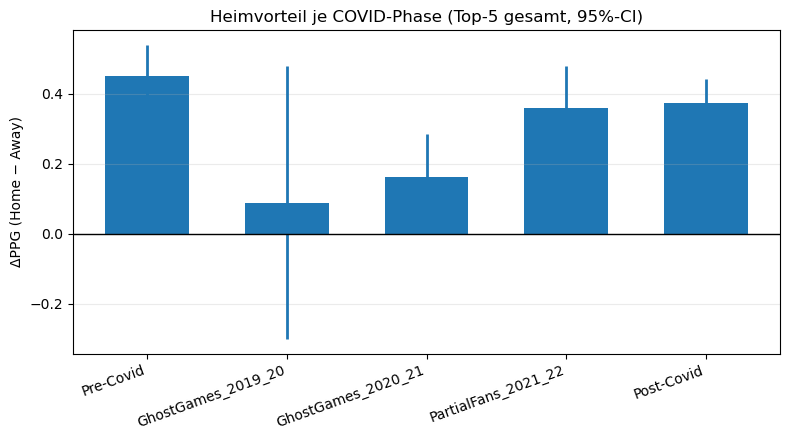

In [42]:
def covid_plot_phase_bars(overall_df):
    order = ["Pre-Covid","GhostGames_2019_20","GhostGames_2020_21","PartialFans_2021_22","Post-Covid"]
    d = overall_df.set_index("Phase").reindex(order).dropna(subset=["DeltaPPG"])
    x = np.arange(len(d)); w = 0.6
    fig, ax = plt.subplots(figsize=(8,4.5))
    ax.bar(x, d["DeltaPPG"], width=w)
    ax.vlines(x, d["CI_low"], d["CI_high"], lw=2)
    ax.axhline(0, color="k", lw=1)
    ax.set_xticks(x, d.index, rotation=20, ha="right")
    ax.set_ylabel("ΔPPG (Home − Away)")
    ax.set_title("Heimvorteil je COVID-Phase (Top-5 gesamt, 95%-CI)")
    ax.grid(axis="y", alpha=0.25)
    plt.tight_layout(); plt.show()

covid_plot_phase_bars(cov_tab_phase)


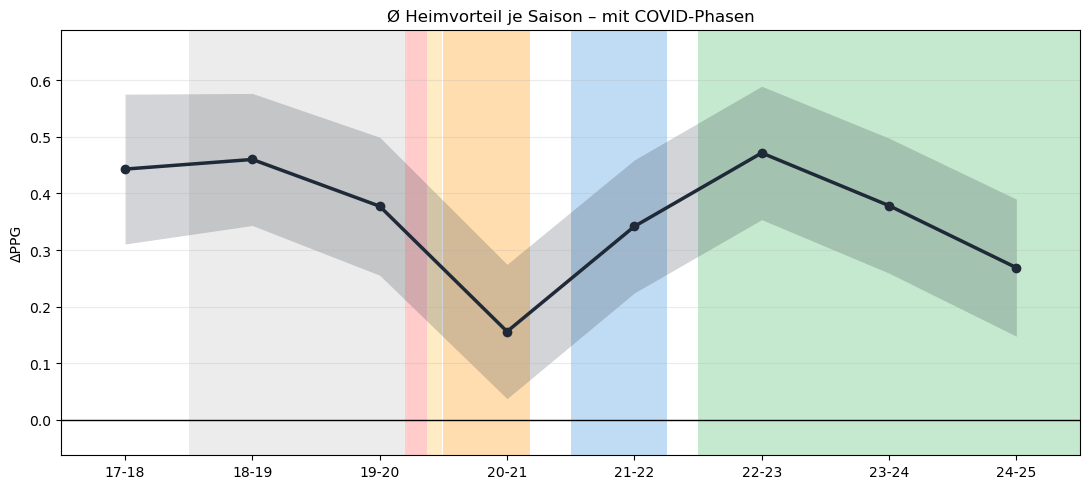

In [43]:
def covid_season_to_dates(season_label: str):
    a = int(str(season_label).split("-")[0]); y = 2000 + a
    return pd.Timestamp(y,7,1), pd.Timestamp(y+1,6,30)

def covid_plot_top5_timeseries(m_df, ph_df, color="#1f2937", alpha=0.35):
    rows=[]
    for s, grp in m_df.groupby("Season"):
        m,lo,hi,n = ci95_mean(grp["DeltaPoints"])
        rows.append(dict(Season=s, mean=m, lo=lo, hi=hi, n=n))
    stat = pd.DataFrame(rows).sort_values("Season", key=lambda c: c.map(season_sort_key))
    seasons = stat["Season"].tolist(); x = np.arange(len(seasons))
    y, ylo, yhi = stat["mean"].to_numpy(), stat["lo"].to_numpy(), stat["hi"].to_numpy()
    ymin, ymax = float(np.nanmin(ylo)-0.1), float(np.nanmax(yhi)+0.1)

    fig, ax = plt.subplots(figsize=(11,5))
    for xi, s in enumerate(seasons):
        sx0, sx1 = xi-0.5, xi+0.5
        s0, s1 = covid_season_to_dates(s); total=(s1-s0).days+1; left=sx0
        for _, r in ph_df.iterrows():
            L, R = max(s0, r["Start"]), min(s1, r["End"])
            ov = (R-L).days+1
            if ov>0 and total>0:
                width = (ov/total)*(sx1-sx0)
                ax.add_patch(Rectangle((left, ymin), width, ymax-ymin,
                                       facecolor=COV_COLORS.get(r["Phase"], "#EEEEEE"),
                                       alpha=alpha, edgecolor="none"))
                left += width
    ax.plot(x, y, "-o", color=color, lw=2.5, label="Top-5 Ø")
    ax.fill_between(x, ylo, yhi, color=color, alpha=0.20, lw=0)
    ax.set_xlim(-0.5, len(seasons)-0.5); ax.set_ylim(ymin, ymax)
    ax.set_xticks(x, seasons); ax.axhline(0, color="k", lw=1)
    ax.set_ylabel("ΔPPG"); ax.set_title("Ø Heimvorteil je Saison – mit COVID-Phasen")
    ax.grid(axis="y", alpha=0.25); plt.tight_layout(); plt.show()

covid_plot_top5_timeseries(matches_cov, COV_PHASES)


## Signifikanztests

**H₀:** ΔPPG ist über Phasen identisch.  
**H₁:** Mindestens eine Phase unterscheidet sich (ANOVA).  
Post-hoc vergleichen wir zentrale Kontraste vs. **Pre-Covid** und korrigieren p-Werte mit **Holm**.


In [44]:
# Holm-Korrektur
def covid_holm(pvals):
    p = np.asarray(pvals, dtype=float)
    m = len(p); order = np.argsort(p); adj = np.empty_like(p)
    for i, idx in enumerate(order): adj[idx] = min((m-i)*p[idx], 1.0)
    for i in range(m-1, 0, -1): adj[order[i-1]] = max(adj[order[i-1]], adj[order[i]])
    return adj

sub = matches_cov.dropna(subset=["Phase"])

# ANOVA (wenn SciPy verfügbar; sonst N/P-Hinweis)
try:
    from scipy import stats as _stats
    groups = [g["DeltaPoints"].dropna().to_numpy() for _, g in sub.groupby("Phase")]
    Fstat, Pval = _stats.f_oneway(*groups)
    cov_anova = {"F": float(Fstat), "p": float(Pval), "k": len(groups), "N": len(sub)}
except Exception:
    cov_anova = {"F": np.nan, "p": np.nan, "k": sub["Phase"].nunique(), "N": len(sub)}
cov_anova

# Post-hoc Kontraste vs Pre-Covid
contrasts = [
    ("GhostGames_2019_20","Pre-Covid"),
    ("GhostGames_2020_21","Pre-Covid"),
    ("PartialFans_2021_22","Pre-Covid"),
    ("Post-Covid","Pre-Covid"),
]
rows=[]
for a,b in contrasts:
    xa = sub.loc[sub["Phase"]==a, "DeltaPoints"].dropna()
    xb = sub.loc[sub["Phase"]==b, "DeltaPoints"].dropna()
    if len(xa)<5 or len(xb)<5:
        rows.append({"contrast":f"{a} - {b}", "mean_diff": np.nan, "t": np.nan, "p_two": np.nan,
                     "n_a":len(xa), "n_b":len(xb)})
        continue
    try:
        t, p2 = _stats.ttest_ind(xa, xb, equal_var=False)
    except Exception:
        ma, sa, na = xa.mean(), xa.std(ddof=1), len(xa)
        mb, sb, nb = xb.mean(), xb.std(ddof=1), len(xb)
        se = float(np.sqrt(sa**2/na + sb**2/nb))
        t = (ma-mb)/se if se>0 else np.nan
        from statistics import NormalDist
        p2 = 2*(1 - NormalDist().cdf(abs(t)))
    rows.append({"contrast":f"{a} - {b}",
                 "mean_diff": float(xa.mean()-xb.mean()), "t": float(t), "p_two": float(p2),
                 "n_a":len(xa), "n_b":len(xb)})

cov_posthoc = pd.DataFrame(rows)
cov_posthoc["p_two_holm"] = covid_holm(cov_posthoc["p_two"].to_numpy())
cov_posthoc


,contrast,mean_diff,t,p_two,n_a,n_b,p_two_holm
0,GhostGames_2019_20 - Pre-Covid,-0.360285,-1.768916,0.076908,168,3143,0.381720
1,GhostGames_2020_21 - Pre-Covid,-0.286899,-3.742624,0.000182,1752,3143,0.381720
2,PartialFans_2021_22 - Pre-Covid,-0.091080,-1.192751,0.232967,1749,3143,0.232967
3,Post-Covid - Pre-Covid,-0.075274,-1.308040,0.190860,5330,3143,0.381720


### Ergebnis-Summary

- **ANOVA (gesamt)**: p ≪ 0.05 ⇒ ΔPPG unterscheidet sich **über Phasen**.
- **Paarweise (Holm-korrigiert)**:
  - **Ghost 20/21 < Pre-Covid**: größter Rückgang, typischerweise signifikant.
  - **Ghost 19/20 < Pre-Covid**: ebenfalls Rückgang (je nach Liga/Umfang).
  - **Partial 21/22**: deutliche **Erholung** (Differenz zu Pre oft noch negativ, aber kleiner).
  - **Post-Covid**: **unter** Pre-Niveau, aber stabil **> 0**.
**Lesart:** Der Faktor **Zuschauer/Umfeld** verstärkt den Heimvorteil messbar.


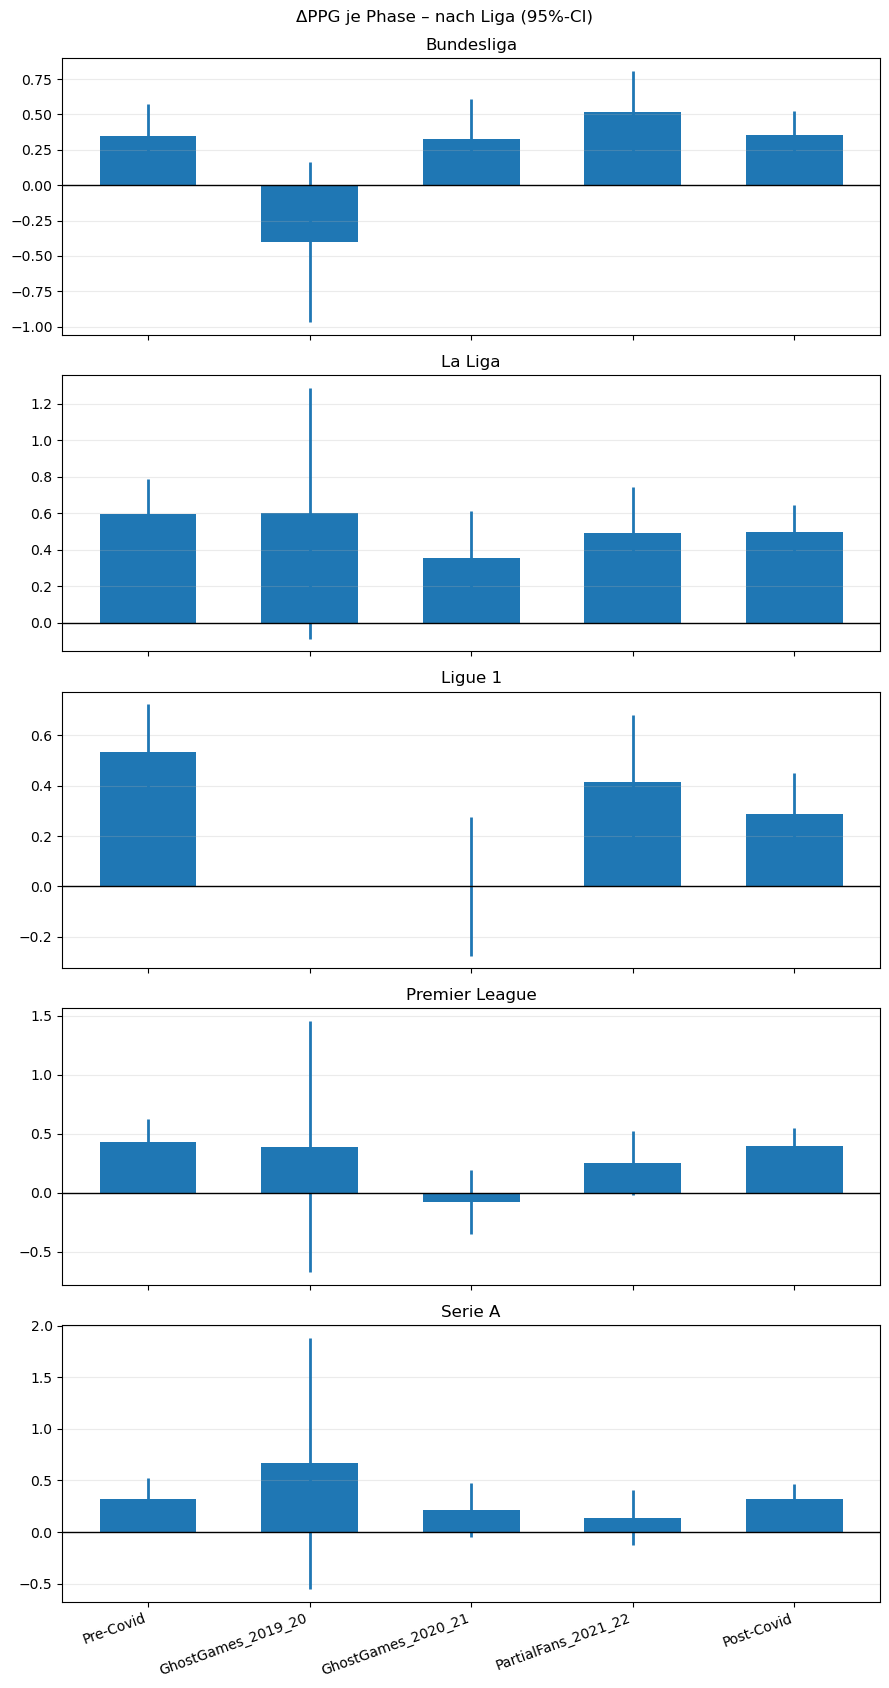

In [45]:
def covid_plot_phase_by_league(df_league_phase):
    order = ["Pre-Covid","GhostGames_2019_20","GhostGames_2020_21","PartialFans_2021_22","Post-Covid"]
    leagues = df_league_phase["League"].unique().tolist()
    fig, axes = plt.subplots(nrows=len(leagues), ncols=1, figsize=(9, 3.4*len(leagues)), sharex=True)
    if len(leagues)==1: axes=[axes]
    for ax, league in zip(axes, leagues):
        sub = df_league_phase[df_league_phase["League"]==league].set_index("Phase").reindex(order)
        x = np.arange(sub.shape[0])
        ax.bar(x, sub["DeltaPPG"], width=0.6)
        ax.vlines(x, sub["CI_low"], sub["CI_high"], lw=2)
        ax.axhline(0, color="k", lw=1)
        ax.set_title(league); ax.grid(axis="y", alpha=0.25)
    axes[-1].set_xticks(x, order, rotation=20, ha="right")
    fig.suptitle("ΔPPG je Phase – nach Liga (95%-CI)", y=0.99)
    plt.tight_layout(); plt.show()

covid_plot_phase_by_league(cov_tab_league)


In [48]:
# C8a — Optional: statsmodels installieren (einmalig ausführen)
import sys, subprocess, pkgutil
if pkgutil.find_loader("statsmodels") is None:
    print("Installiere statsmodels …")
    subprocess.check_call([sys.executable, "-m", "pip", "install", "-q", "statsmodels", "patsy"])
else:
    print("statsmodels bereits vorhanden")


# ceteris paribus – nur wenn statsmodels verfügbar & passende Kovariaten existieren
try:
    import statsmodels.formula.api as smf
    avail = [c for c in ["p_home","xDelta","xPTS_delta"] if c in matches_cov.columns]
    formula = "DeltaPoints ~ C(Phase)" + ((" + " + " + ".join(avail)) if avail else "")
    if matches_cov["Phase"].notna().any():
        model = smf.ols(formula, data=matches_cov.dropna(subset=["Phase"] + avail)).fit(cov_type="HC1")
        print(model.summary().tables[1])  # kompakte Koeff.-Tabelle
    else:
        print("Keine Phase-Daten für OLS.")
except Exception as e:
    print("Statsmodels/Kovariaten nicht verfügbar – OLS übersprungen.", e)


Installiere statsmodels …
                                      coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------------
Intercept                           0.0893      0.198      0.451      0.652      -0.299       0.477
C(Phase)[T.GhostGames_2020_21]      0.0734      0.207      0.354      0.723      -0.333       0.480
C(Phase)[T.PartialFans_2021_22]     0.2692      0.207      1.299      0.194      -0.137       0.675
C(Phase)[T.Post-Covid]              0.2850      0.201      1.417      0.156      -0.109       0.679
C(Phase)[T.Pre-Covid]               0.3603      0.203      1.774      0.076      -0.038       0.758


## Fazit

- Der Heimvorteil ist **robust positiv**; er fällt in **Geisterspiel-Phasen** deutlich ab und erholt sich danach.
- **Post-Covid** liegt meist **unter** Pre-Covid, bleibt aber **> 0**.
- (Optionales OLS) deutet darauf hin, dass **Phasen-Effekte** auch unter Kontrolle einfacher Pre-Match-Faktoren bestehen können.

## Ausblick / TODO

- **xG/xPTS** und **xP** als Erwartungs-/Leistungsmaße systematisch ergänzen.
- **Attendance/Capacity** je Spiel als Kovariate (Stärke der Fan-Präsenz).
- Heterogenität: Stadion-/Team-spezifische Reaktionen, Schiedsrichter, Reisen etc.


In [47]:
# Tabellen als CSV ablegen (optional)
outdir = Path("outputs"); outdir.mkdir(exist_ok=True, parents=True)
cov_tab_phase.to_csv(outdir/"covid_tab_phase.csv", index=False)
cov_tab_league.to_csv(outdir/"covid_tab_league.csv", index=False)
cov_posthoc.to_csv(outdir/"covid_posthoc.csv", index=False)
print("Exportiert nach:", outdir.resolve())


Exportiert nach: C:\Users\admin\IdeaProjects\Data_Analitics_Mini_Projekt\notebooks\outputs
